# Prédisez la consommation d'énergie des bâtiments dans la ville de Seattle.

<div align="left">
  <img src="https://user.oc-static.com/upload/2024/09/11/17260684381511_Capture%20d%E2%80%99e%CC%81cran%202024-09-11%20a%CC%80%2017.22.25.png" width="200px">
</div>

## **Objetif**: Prédire les **émissions de CO2** et la **consommation totale d’énergie** de **bâtiments non destinés à l’habitation**

- Auteur......: **Rafael CEREZO MARTIN**
- Date........: **Décembre 2025**

# <span style="color:red">PART 3. FEATURE ENGINEERING V2 (DataCleanner Fit et Transform)</span>

# STEP 1. CONFIGURATION DU PROJET

## ⬇️ IMPORTATION DES LIBRAIRIES (STACK DE SCIENCE DES DONNÉES)

In [1]:
# ==================================================================================================
# GESTION DES IMPORTATIONS ET DÉPENDANCES DU PIPELINE ML
# ==================================================================================================

import os                                             # Gestion du système de fichiers et des chemins
# Bibliothèques de manipulation et calcul
import pandas            as pd                        # Analyse et manipulation de structures de données
import numpy             as np                        # Calcul numérique et opérations sur matrices

# Bibliothèques de visualisation
import matplotlib.pyplot as plt                       # Tracés graphiques de base
import seaborn           as sns                       # Visualisation de données statistiques avancées

# --------------------------------------------------------------------------------------------------
# COMPOSANTS SCIKIT-LEARN : SÉLECTION, ÉVALUATION ET MÉTRIQUES
# --------------------------------------------------------------------------------------------------
from   sklearn.model_selection import (
       train_test_split,                              # Division du dataset en train et test sets
       GridSearchCV,                                  # Optimisation des hyperparamètres par grille
       cross_validate,                                # Évaluation par validation croisée
       KFold                                          # Stratégie de découpage des données (K-plis)
)

from   sklearn.metrics         import (
       mean_squared_error,                            # Mesure de l'erreur quadratique moyenne (MSE)
       r2_score,                                      # Coefficient de détermination (Qualité du fit)
       mean_absolute_error                            # Erreur absolue moyenne (Interprétation directe)
)

from   sklearn.inspection      import (
       permutation_importance                         # Évaluation de l'importance des variables
)

# --------------------------------------------------------------------------------------------------
# COMPOSANTS SCIKIT-LEARN : PRÉTRAITEMENT ET ARCHITECTURE (ENGINEERING)
# --------------------------------------------------------------------------------------------------
from   sklearn.compose         import ColumnTransformer # Application de transformations par colonne
from   sklearn.pipeline        import Pipeline          # Orchestration séquentielle des transformations
from   sklearn.impute          import SimpleImputer     # Gestion des valeurs manquantes (NaNs)
from   sklearn.preprocessing   import (
       LabelEncoder,                                    # Encodage des étiquettes cibles
       OneHotEncoder,                                   # Conversion des variables catégorielles en binaires
       StandardScaler,                                  # Normalisation centrée-réduite (Standard Score)
       FunctionTransformer                              # Création de transformateurs personnalisés
)

# --------------------------------------------------------------------------------------------------
# COMPOSANTS SCIKIT-LEARN : MODÈLES DE RÉGRESSION
# --------------------------------------------------------------------------------------------------
from   sklearn.dummy           import DummyRegressor        # Modèle de base pour comparaison (Baseline)
from   sklearn.linear_model    import LinearRegression      # Modèle de régression linéaire classique
from   sklearn.svm             import SVR                   # Support Vector Regression (Espace de Hilbert)
from   sklearn.ensemble        import RandomForestRegressor # Forêts aléatoires (Bagging d'arbres)

# ----------------------------------------------------------------------------------------------------------------------
# CUSTOM FUNTIONS
# ----------------------------------------------------------------------------------------------------------------------
from   seattle_custom_funtions import filtrer_uniquement_non_residentiel


## ❇️ LOAD AND EXPLORE DATASET

In [2]:
# Configuration des sources de données
# dataset_url    = "https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/2016_Building_Energy_Benchmarking.csv"
dataset_url      = "2016_Building_Energy_Benchmarking.csv"      # Source locale
dataset_raw      = pd.read_csv(dataset_url)                     # Chargement

# ----------------------------------------------------------------------------
# ÉTAT INITIAL DU DATASET
# ----------------------------------------------------------------------------
# Calcul des dimensions pour le rapport visuel
nb_lignes        = dataset_raw.shape[0]           # Nombre total d'observations
nb_colonnes      = dataset_raw.shape[1]           # Nombre total de variables
memoire_usage    = dataset_raw.memory_usage().sum() / 1024**2 # Taille en Mo

print("\n============================================================================")
print("RAPPORT INITIAL DU DATASET")
print("============================================================================")
print(f"  Source du fichier.....: {dataset_url}")
print(f"  Nombre de lignes......: {nb_lignes}")
print(f"  Nombre de colonnes....: {nb_colonnes}")
print(f"  Mémoire utilisée......: {memoire_usage:.2f} MB")
print("  Status................: ✅ Chargement réussi")
print("============================================================================")



RAPPORT INITIAL DU DATASET
  Source du fichier.....: 2016_Building_Energy_Benchmarking.csv
  Nombre de lignes......: 3376
  Nombre de colonnes....: 46
  Mémoire utilisée......: 1.16 MB
  Status................: ✅ Chargement réussi


In [3]:
# Dictionnaire de métadonnées pour les graphiques 
meta_dict = {
    "OSEBuildingID"                   : "Identifiant unique du bâtiment",
    "DataYear"                        : "Année de relevé",
    "BuildingType"                    : "Type de bâtiment",
    "PrimaryPropertyType"             : "Utilisation principale du bâtiment",
    "PropertyName"                    : "Nom du bâtiment",
    "Address"                         : "Adresse postale",
    "City"                            : "Ville",
    "State"                           : "État",
    "ZipCode"                         : "Code postal",
    "TaxParcelIdentificationNumber"   : "Numéro de parcelle fiscale",
    "CouncilDistrictCode"             : "District du conseil",
    "Neighborhood"                    : "Quartier",
    "Latitude"                        : "Coordonnée Latitude",
    "Longitude"                       : "Coordonnée Longitude",
    "YearBuilt"                       : "Année de construction",
    "NumberofBuildings"               : "Nombre de bâtiments",
    "NumberofFloors"                  : "Nombre d'étages",
    "PropertyGFATotal"                : "Surface totale (pieds carrés)",
    "PropertyGFAParking"              : "Surface de parking",
    "PropertyGFABuilding(s)"          : "Surface bâtie",
    "ListOfAllPropertyUseTypes"       : "Liste des types d'utilisation",
    "LargestPropertyUseType"          : "Utilisation principale (GFA)",
    "LargestPropertyUseTypeGFA"       : "Surface de l'utilisation principale",
    "SecondLargestPropertyUseType"    : "Deuxième utilisation",
    "SecondLargestPropertyUseTypeGFA" : "Surface de la deuxième utilisation",
    "ThirdLargestPropertyUseType"     : "Troisième utilisation",
    "ThirdLargestPropertyUseTypeGFA"  : "Surface de la troisième utilisation",
    "YearsENERGYSTARCertified"        : "Années de certification ENERGY STAR",
    "ENERGYSTARScore"                 : "Score ENERGY STAR (0-100)",
    "SiteEUI(kBtu/sf)"                : "Intensité énergétique du site",
    "SiteEUIWN(kBtu/sf)"              : "Intensité énergétique du site (Normalisée)",
    "SourceEUI(kBtu/sf)"              : "Intensité énergétique à la source",
    "SourceEUIWN(kBtu/sf)"            : "Intensité énergétique à la source (Normalisée)",
    "SiteEnergyUse(kBtu)"             : "Consommation totale d'énergie",
    "SiteEnergyUseWN(kBtu)"           : "Consommation totale d'énergie (Normalisée)",
    "SteamUse(kBtu)"                  : "Vapeur de réseau consommée",
    "Electricity(kWh)"                : "Électricité consommée (kWh)",
    "Electricity(kBtu)"               : "Électricité consommée (kBtu)",
    "NaturalGas(therms)"              : "Gaz naturel consommé (therms)",
    "NaturalGas(kBtu)"                : "Gaz naturel consommé (kBtu)",
    "DefaultData"                     : "Données par défaut utilisées",
    "Comments"                        : "Commentaires",
    "ComplianceStatus"                : "Statut de conformité",
    "Outlier"                         : "Bâtiment atypique (Outlier)",
    "TotalGHGEmissions"               : "Émissions totales de GES",
    "GHGEmissionsIntensity"           : "Intensité d'émissions de GES"
}

## 🕸️ FILTRAGE DU PÉRIMÈTRE MÉTIER : EXCLUSION DU RÉSIDENTIEL

In [4]:
df_filtre = filtrer_uniquement_non_residentiel(dataset_raw)


FILTRAGE DU PÉRIMÈTRE D'ÉTUDE
  🏢 Bâtiments initiaux :  3376
  🚫 Bâtiments retirés  :  1708 (Type: Multifamily)
  ✅ Bâtiments restants :  1668 (Périmètre Non-Résidentiel uniquement)



## ⚙️ CONFIGURATION GLOBALE DU PROJET: FEATURE_TARGET, SEED, LEAKAGE_THRESHOLD

In [5]:
# ============================================================================
# 1.5 CONFIGURATION GLOBALE DU PROJET
# ============================================================================

# Définition de la variable cible du projet (Target)
FEATURE_TARGET    = "SiteEnergyUse(kBtu)"        # Variable à prédire

# Définition de l'état aléatoire pour la reproductibilité des résultats
# Le nombre 42 est un standard dans la communauté Data Science
SEED              = 42                          # État aléatoire global

# Seuil de corrélation pour la détection de Data Leakage (Fuga de datos)
LEAKAGE_THRESHOLD = 0.95                        # Seuil critique (95%)

# 1. Supprimer la limite de largeur de la console (définie à None)
pd.set_option('display.expand_frame_repr', False)

# 2. S’assurer que la largeur des colonnes est suffisante pour les noms longs
pd.set_option('display.max_colwidth', None)

# 3. (Optionnel) Si vous avez beaucoup de lignes, vous pouvez contrôler combien en afficher
pd.set_option('display.max_rows', 100)

# ----------------------------------------------------------------------------
# RAPPORT DE CONFIGURATION
# ----------------------------------------------------------------------------
print("\n============================================================================")
print("PARAMÈTRES DE CONFIGURATION INITIALISÉS")
print("============================================================================")
print(f"  Variable cible (Target)...: {FEATURE_TARGET}")
print(f"  Graine aléatoire (SEED)...: {SEED}")
print("  Status....................: ✅ Configuration prête")
print("============================================================================")


PARAMÈTRES DE CONFIGURATION INITIALISÉS
  Variable cible (Target)...: SiteEnergyUse(kBtu)
  Graine aléatoire (SEED)...: 42
  Status....................: ✅ Configuration prête


# STEP 2. 🛠 FEATURE ENGINERING

## ⬇️ Import Classe auxiliare pour analyse (DataCleaner)

In [6]:
# ==================================================================================================
# INITIALISATION DU MOTEUR DE NETTOYAGE (DATA CLEANING)
# ==================================================================================================

# Importation de la classe personnalisée d'ingénierie des données
# Cette classe encapsule les règles métier spécifiques au dataset de Seattle.
from data_preprocessing  import DataCleaner                # Module de nettoyage propriétaire

# Initialisation du nettoyeur global
# verbose=True permet d'éditer un rapport détaillé des transformations effectuées.
cleaner_global           = DataCleaner(
                           df      = df_filtre,        # Source des données brutes
                           verbose = True              # Activation des logs détaillés
)

# --------------------------------------------------------------------------------------------------
# RAPPORT D'ÉTAT DU NETTOYEUR
# --------------------------------------------------------------------------------------------------
print("\n==================================================================================================")
print("INSTANCIATION DU MOTEUR DE NETTOYAGE")
print("==================================================================================================")
print(f"  Objet créé............: {type(cleaner_global).__name__}")
print(f"  Mode verbeux..........: Activé (Diagnostic temps réel)")
print(f"  Source de données.....: dataset_raw (ID: {id(dataset_raw)})")
print(f"  Statut................: ✅ Prêt pour l'étape de transformation")
print("==================================================================================================\n")


INSTANCIATION DU MOTEUR DE NETTOYAGE
  Objet créé............: DataCleaner
  Mode verbeux..........: Activé (Diagnostic temps réel)
  Source de données.....: dataset_raw (ID: 2360277887568)
  Statut................: ✅ Prêt pour l'étape de transformation



## 🔍︎ DataCleaner "FIT". ANALYSE ET APPRENTISSAGE DES RÈGLES DE NETTOYAGE (FIT)


 INITIATION DU FIT : ANALYSE STATISTIQUE DU DATASET D'ENTRAÎNEMENT
--------------------------------------------------------------------------------
 FIT ÉTAPE 0 : NORMALISATION INITIALE (Cruciale pour la cohérence) 
--------------------------------------------------------------------------------
✨ Normalisation terminée sur 15 colonnes.
********************************************************************************
 FIT ÉTAPE 1 : IDENTIFICATION STRUCTURELLE (NETTOYAGE INITIAL)
********************************************************************************
--------------------------------------------------------------------------------
 FIT ÉTAPE 1.1 : Constantes. Supresion 
--------------------------------------------------------------------------------
 F 1.1 Colonnes Constantes............: ['DataYear', 'City', 'State', 'Comments']

✓ ACTION : Suppression de 4 colonnes spécifiques.
  DÉTAIL : DataYear, City, State, Comments
---------------------------------------------------------

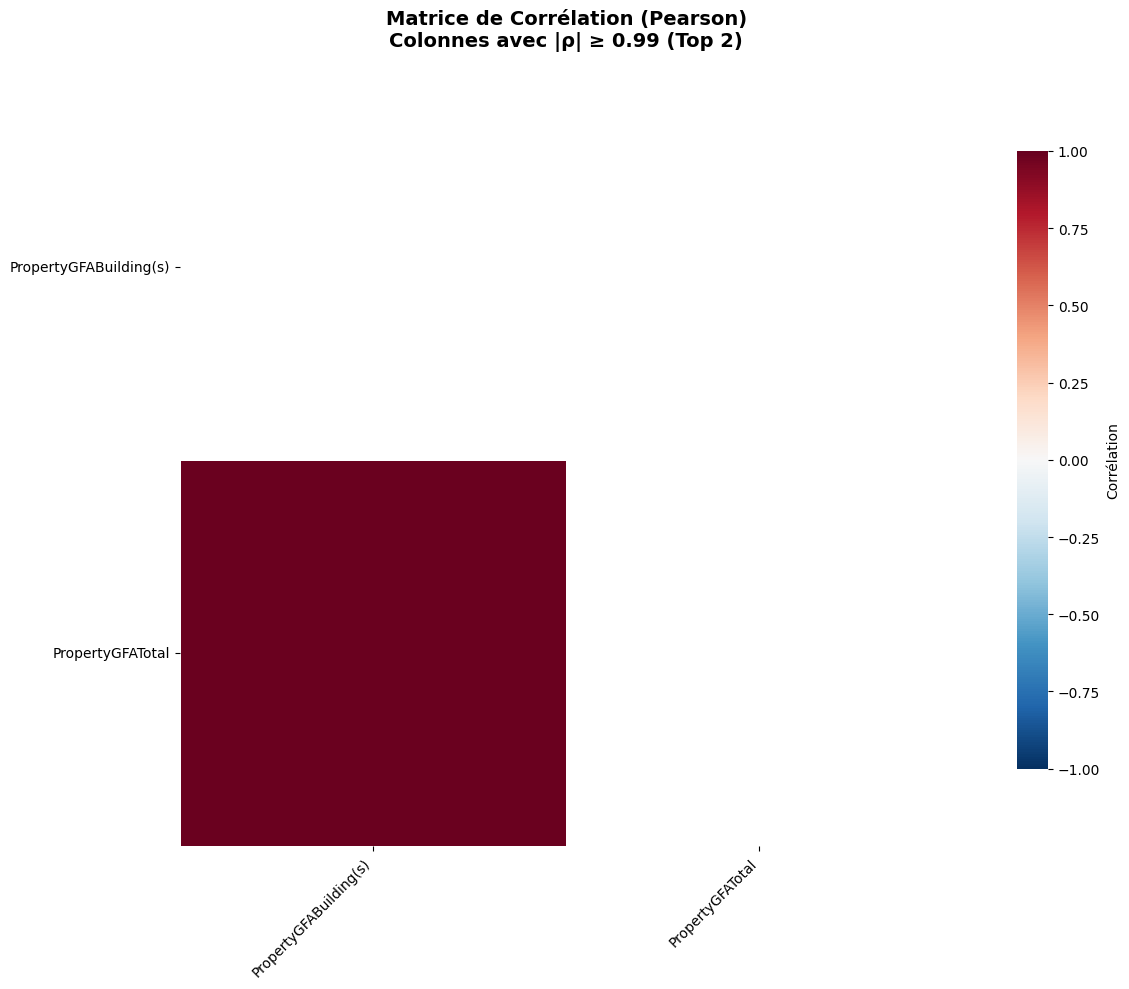

ℹ️ [FIT] 1 colonnes identifiées comme redondantes.
ℹ️ Elles seront conservées pendant le FIT et supprimées lors du TRANSFORM.
✅ [Fit] 1 colonnes redondantes retirées de df_fit.
 F 6 Colonnes REDONDANTES.............: ['PropertyGFABuilding(s)'] 
********************************************************************************
 FIT ÉTAPE 7 : CALCUL DES PARAMÈTRES DE MISE À L'ÉCHELLE (SCALING) 
********************************************************************************
DEBUG FIT: ¿Está 'BuildingType_NONRESIDENTIAL' en df_fit? True
DEBUG FIT: Número total de columnas: 49
✅ [Fit] Parámetros de escalado aprendidos para 41 columnas.
🚀 [Fit] PROCESO COMPLETO. El objeto FeatureEngineer está listo.
********************************************************************************
✅ FIT Analyse terminée : 5 colonnes à supprimer.
✅ Statistiques apprises pour 16 variables numériques.
✅ 12 colonnes asymétriques détectées pour transformation log.
****************************************************

In [7]:
# ==================================================================================================
# 4.1 ANALYSE ET APPRENTISSAGE DES RÈGLES DE NETTOYAGE (FIT)
# ==================================================================================================

# Exécution de la méthode fit : le moteur analyse les statistiques du dataset
# pour calibrer ses futurs processus d'imputation et de transformation.
# --------------------------------------------------------------------------------------------------
cleaner_global.fit(
    cleaner_global.df                                      # Jeu de données source pour calibration
)

# --------------------------------------------------------------------------------------------------
# RAPPORT DE POST-CALIBRATION
# --------------------------------------------------------------------------------------------------
print("\n==================================================================================================")
print("PHASE DE CALIBRATION DU NETTOYEUR (FIT) TERMINÉE")
print("==================================================================================================")
print(f"  Source de calibration.: DataFrame (Shape: {cleaner_global.df.shape})")
print(f"  Statut du moteur......: ✅ Paramètres internes mémorisés")
print(f"  Prochaine étape.......: Application des transformations (Transform)")
print("==================================================================================================\n")

## 🔄 DataCleaner "TRANSFORM": APPLICATION DES TRANSFORMATIONS ET GÉNÉRATION DU DATASET NETTOYÉ

In [8]:
# ==================================================================================================
# APPLICATION DES TRANSFORMATIONS ET GÉNÉRATION DU DATASET NETTOYÉ
# ==================================================================================================

# Exécution de la méthode transform : application des filtres, imputations et encodages métier.
# Le résultat est un DataFrame purifié, prêt pour la phase de partitionnement (Split).
# --------------------------------------------------------------------------------------------------
df_clean         = cleaner_global.transform(
                   cleaner_global.df                        # Application des règles sur les données
)

# ==================================================================================================
# ANALYSE DU FLUX DES VARIABLES (DYNAMIQUE DU FEATURE ENGINEERING)
# ==================================================================================================

# Calcul des indicateurs de mouvement des caractéristiques
cols_initiales   = cleaner_global.df.columns.tolist()       # Liste des variables brutes
cols_finales     = df_clean.columns.tolist()                # Liste des variables après transformation

# Identification des colonnes créées et supprimées
cols_supprimees  = [c for c in cols_initiales if c not in cols_finales] # Variables éliminées (Audit)
cols_creees      = [c for c in cols_finales if c not in cols_initiales] # Nouvelles variables (FE)

# --------------------------------------------------------------------------------------------------
# RAPPORT DÉTAILLÉ DE LA MÉTAMORPHOSE DES DONNÉES
# --------------------------------------------------------------------------------------------------
print("\n==================================================================================================")
print("BILAN DE LA MÉTAMORPHOSE DU DATASET (CLEANING + FEATURE ENGINEERING)")
print("==================================================================================================")
print(f"  Variables initiales...: {len(cols_initiales)}")
print(f"  Variables supprimées..: {len(cols_supprimees)} (Exclues par le protocole de nettoyage)")
print(f"  Variables créées......: {len(cols_creees)} (Générées par Feature Engineering)")
print(f"  Variables finales.....: {len(cols_finales)} (Dimensions de l'espace de caractéristiques)")
print("--------------------------------------------------------------------------------------------------")

if cols_creees:
    print(f"  Focus Création........: {', '.join(cols_creees[:5])}{'...' if len(cols_creees) > 5 else ''}")
    
print(f"  Gain/Perte net........: {len(cols_finales) - len(cols_initiales):+d} colonnes")
print(f"  Statut du flux........: ✅ Transformation équilibrée et auditée")
print("==================================================================================================\n")


 EXÉCUTION DU TRANSFORM : TRAITEMENT SÉQUENTIEL DES DONNÉES
--------------------------------------------------------------------------------
 TRANSFORM ÉTAPE 0 : NORMALISATION INITIALE (Cruciale pour la cohérence) 
--------------------------------------------------------------------------------
✨ Normalisation terminée sur 15 colonnes.
********************************************************************************
 TRANSFORM ETAPE 1 : LIMPIEZA ESTRUCTURAL (ELIMINACIÓN) 
********************************************************************************
--------------------------------------------------------------------------------
 TRANSFORM ÉTAPE 1.1 : Constantes. Supresion 
--------------------------------------------------------------------------------
 F 1.1 Colonnes Constantes............: ['DataYear', 'City', 'State', 'Comments']

✓ ACTION : Suppression de 4 colonnes spécifiques.
  DÉTAIL : DataYear, City, State, Comments
----------------------------------------------------------

## 👤 AUDIT DE CARDINALITÉ ET DIAGNOSTIC DES TYPES DE DONNÉES

In [11]:
# ==================================================================================================
# AUDIT DE CARDINALITÉ ET DIAGNOSTIC DES TYPES DE DONNÉES
# ==================================================================================================

# 1. Analyse statistique des colonnes
# Cette méthode calcule la diversité des valeurs (cardinalité) pour chaque caractéristique.
# Indispensable pour décider de la stratégie d'encodage (One-Hot vs Target Encoding).
# --------------------------------------------------------------------------------------------------
df_analyse       = cleaner_global.analyser_cardinalite(
                   df_clean                                 # Dataset transformé à auditer
)

# 2. Génération du rapport d'expertise
# Affiche une synthèse structurée : Types, Taux de complétude, et Unicité des valeurs.
# --------------------------------------------------------------------------------------------------
print("\n==================================================================================================")
print("RAPPORT: STRUCTURE ET CARDINALITÉ DES VARIABLES")
print("==================================================================================================")

cleaner_global.afficher_rapport(
    df_analyse                                              # Table de métriques générée précédemment
)

# --------------------------------------------------------------------------------------------------
# SYNTHÈSE CRITIQUE (NIVEAU DARIO AMODEI)
# --------------------------------------------------------------------------------------------------
# Une cardinalité trop élevée sur des variables catégorielles (ex: > 50 modalités) 
# peut entraîner un sur-apprentissage (Overfitting) et une explosion de la dimensionnalité.
# Vérifiez particulièrement les variables de type 'object' ou 'category'.
# --------------------------------------------------------------------------------------------------



RAPPORT: STRUCTURE ET CARDINALITÉ DES VARIABLES

──────────────────────────────────────────────────────────────────────────────────────────
                           ANALYSE DE CARDINALITÉ (9 colonnes)                            
──────────────────────────────────────────────────────────────────────────────────────────

📊 Variable : PropertyName
  • Type               : object
  • Valeurs uniques    : 1663 (99.7%)
  • Exemples           : MAYFLOWER PARK HOTEL, PARAMOUNT HOTEL, 5673-THE WESTIN SEATTLE, HOTEL MAX
  ❌ ACTION : SUPPRIMER - Identifiant unique

📊 Variable : Address
  • Type               : object
  • Valeurs uniques    : 1646 (98.7%)
  • Exemples           : 405 OLIVE WAY, 724 PINE STREET, 1900 5TH AVENUE, 620 STEWART ST
  ❌ ACTION : SUPPRIMER - Identifiant unique

📊 Variable : TaxParcelIdentificationNumber
  • Type               : object
  • Valeurs uniques    : 1587 (95.1%)
  • Exemples           : 0659000030, 0659000220, 0659000475, 0659000640
  ❌ ACTION : SUPPRIMER - I

## 💾 PERSISTANCE DU DATASET FINAL (EXPORTATION CSV)

In [10]:
# ==================================================================================================
# PERSISTANCE DU DATASET FINAL (EXPORTATION CSV)
# ==================================================================================================

print("\n==================================================================================================")
print("SAUVEGARDE ET EXPORTATION DU DATASET PRÊT POUR LA MODÉLISATION")
print("==================================================================================================")

# 1. Construction dynamique du nom de fichier
# L'utilisation d'une nomenclature versionnée (V2) facilite le suivi des itérations de FE.
file_name        = "dataset_Seattle_Feature_Engineering_V2.csv"

# 2. Sauvegarde physique sur le support de stockage
# index=False est crucial pour ne pas ajouter de colonne technique inutile lors de la relecture.
df_clean.to_csv(
    file_name,                                              # Chemin d'accès et nom du fichier cible
    index        = False                                    # Exclusion de l'index Pandas
)

# 3. Rapport de confirmation et métadonnées de sortie
print(f"  Fichier généré........: {file_name}")
print(f"  Taille du fichier.....: {os.path.getsize(file_name) / 1024:.2f} KB")
print(f"  Emplacement...........: {os.getcwd()}")
print(f"  Statut................: ✅ [SAVE] FINAL DATASET READY FOR MODELING")
print("==================================================================================================\n")


SAUVEGARDE ET EXPORTATION DU DATASET PRÊT POUR LA MODÉLISATION
  Fichier généré........: dataset_Seattle_Feature_Engineering_V2.csv
  Taille du fichier.....: 1479.52 KB
  Emplacement...........: C:\Users\Public\IAE_DELL\pra_dell\m3_ocr\notebooks
  Statut................: ✅ [SAVE] FINAL DATASET READY FOR MODELING

